## Построение доверительных характеристик (доверительных интервалов и коридоров) для динамических моделей на основе профиля правдоподобия

Иван Борисов, Евгений Метелкин<br/> 
Отдел разработки, ООО «ИНСИСБИО»

### План

- Введение. Идентифицируемость и доверительные характеристики модели
- Методы анализа идентифицируемости
- Методы идентификации параметров на основе профиля правдоподобия
- Taxol treatment model : оценка доверительных интервалов и коридоров

## Идентифицируемость модели

Общий вид кинетической модели в Системной биологии:
\begin{align}
\frac{dx(t)}{dt} & = f(x(t),u(t),\theta) \\
x(0) & = x_0 \\
y(t,\theta) & = g(x(t),\theta)+\epsilon(t)
\end{align}

- $x(t)$ - переменные системы ОДУ с известной правой частью $f$
- $y(t, \theta)$ - наблюдения с известной функцией $g$
- $u(t)$ - известная функция управления
- $\epsilon(t)$ - известная модель ошибки
- {$\theta, x_0$} - набор, содержащий известные и неизвестные параметры модели

### Валидация модели:

- Выбор структурно-идентифицируемой параметризации модели
- Анализ практической идентифицируемости параметров
- Построение доверительных интервалов для параметров и предсказаний

## Практическая идентификация и доверительные интервалы

Практическая идентифицируемость характеризуется доверительными интервалами (Confidence Intervals, CI) для оценок параметров. Некоторые методы построения CI:

- Bayesian approach
- Variance–Covariance analysis
- Bootstrap method
- Profile Likelihood
- etc.

## Метод профиля правдоподобия (Profile Likelihood)

Метод заключается в исследовании функции правдоподобия $L(\theta)$ как функции от одного (интересующего нас) параметра:
\begin{align}
l_{PL}(\theta_i) = \min\limits_{\theta_{i \neq j}}(\Lambda(\theta)), \quad \Lambda(\theta) = -2\log(L(\theta)), \\
\end{align}

![](pl_raue.jpg "Practical Identifiability")
[Raue et all, 2010](https://pubmed.ncbi.nlm.nih.gov/21198117/)

## Вычисление профиля правдоподобия

- «Repeated optimization» - пошаговый метод, вытекающий напрямую из определения профиля правдоподобия 
- «Integration based» метод позволяет получить профиль как решение системы уравнений, которая вытекает из дифференцирования Лагранжиана: $l(\theta) + \lambda(\theta_i  − c)$

![](pl_2methods.jpg "Practical Identifiability")
[Boiger et all, 2016](https://arxiv.org/abs/1604.02894)

## Недостатки существующих реализаций профиля правдоподобия

- Вычислительные затраты метода
- Необходимость восстанавливать форму профиля для того, чтобы получить границы доверительных интервалов
- Избыточные требования к вычислительным ресурсам для расчета доверительных коридоров 

## Confidence Intervals by Constrained Optimization Method

Цель метода: с заданной точностью вычислять граничные точки доверительных интервалов без восстановления формы профиля

![](venzon1.jpg "Practical Identifiability")
![](venzon2.jpg "Practical Identifiability")
[Venzon and Moolgavkar, 1988](https://www.jstor.org/stable/2347496)

## Confidence Intervals by Constrained Optimization Method


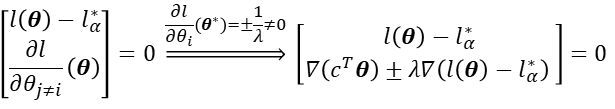
где $c_j = \begin{equation} \begin{cases} 0, i \neq j\\ 1, i = j \end{cases}\ \end{equation},  l_\alpha^*=l(\theta^*)+∆_\alpha$ - значение функции правдоподобия, отвечающее оптимальной оценке параметров $\theta^*$ и заданному уровню значимости $∆_𝛼$
Система определяет необходимые условия существования решения оптимизационной задачи с Лагранжианом:
\begin{align}
L(\theta, \lambda) = \pm \theta_i + \lambda(l(\theta)-l_\alpha^*)
\end{align}

## LikelihoodProfiler.jl - Численная реализация метода

- Алгоритм CICO реализован в программном пакете c открытым кодом [LikelihoodProfiler.jl](https://github.com/insysbio/LikelihoodProfiler.jl) . Пакет написан на языке [Julia](https://github.com/insysbio/LikelihoodProfiler.jl)
- Для решения оптимизационной задачи используется алгоритм AUGLAG (Augemented Lagrangian) из библиотеки [Nlopt.jl](https://nlopt.readthedocs.io/)
- Библиотека позволяет выбрать как градиентный, так и безградиентный метод локальной оптимизации 

[Borisov I, Metelkin E (2020) Confidence intervals by constrained optimization—An algorithm and software package for practical identifiability analysis in systems biology](https://doi.org/10.1371/journal.pcbi.1008495)

## Cancer Taxol Treatment Model
Для иллюстрации метода рассмотрим модель [Marisa C.Eisenberg, Harsh V.Jain. A confidence building exercise in data and identifiability](https://www.sciencedirect.com/science/article/pii/S0022519317303454)


In [1]:
using DiffEqBase, OrdinaryDiffEq, Plots, DataFrames, CSV, Distributions, LikelihoodProfiler
import Statistics: mean

const K   = 10.515*100
const V0  = 1.3907*K
const lam = 9.5722
const theta = 10.
const aRP  = 20.
const arstexp = 3.
const adthexp = 4.;

In [2]:
# https://github.com/marisae/cancer-chemo-identifiability/blob/master/Profile%20Likelihood/testa0_de.m
function ode_func(du, u, θ, t, drug)
    (a0, ka, r0, d0, kd) = (θ[1],θ[2],θ[3],θ[4],θ[5])

    Ncel = u[1] + u[2] + u[3]
    Lfac = ((K-Ncel)^theta)/((V0^theta) + ((K-Ncel)^theta))
    arst = a0*(drug^arstexp)/(ka^arstexp + (drug^arstexp))
    adth = d0*(drug^adthexp)/(kd^adthexp + (drug^adthexp))
    arcv = r0
    
    # The differential equations
    du[1] = -lam*u[1] + aRP*u[2]*Lfac - arst*u[1] + arcv*u[3]
    du[2] = 2*lam*u[1] - aRP*u[2]*Lfac
    du[3] = arst*u[1] - adth*u[3] - arcv*u[3]
end;

Экспериментальные данные:

In [3]:
df = CSV.read("taxol_data.csv", DataFrame)
dose = [5., 10., 40., 100.]

times = df.times
C005 = mean(df.Cell005)
C010 = mean(df.Cell010)
C040 = mean(df.Cell040)
C100 = mean(df.Cell100)

data = [df.Cell005/C005, df.Cell010/C010, df.Cell040/C040, df.Cell100/C100]
datamean = [C005, C010, C040, C100];

Целевая функция:
$$ \Lambda(\theta) = \sum_{i=1}^n \left( y(t_i,θ) - data_i \right)^2 $$

In [4]:
function lsq_func(θ)
    loss = 0.
    for (i,d) in enumerate(dose)
       prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,d), u0, tspan, θ)
       sol = solve(prob, AutoTsit5(Rosenbrock23()), saveat=times)
        
       sim = (sol[1,:] + sol[2,:] + sol[3,:])/datamean[i]
       loss += sum((sim-data[i]).^2)
    end
    return loss
end;

Значения параметров, полученные в результате "фиттинга":

In [5]:
# best fit values
u0 = [7.2700, 2.5490, 0.]
θ0 = [8.3170, 8.0959, 0.0582, 1.3307, 119.1363];

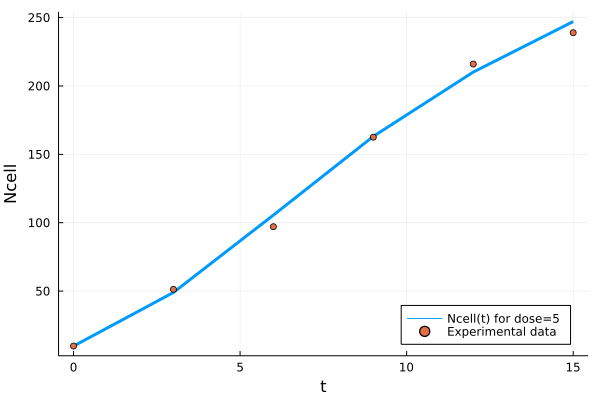

In [9]:
tspan = (0.,15.)
prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,5.0), u0, tspan, θ0)
sol = solve(prob, AutoTsit5(Rosenbrock23()), saveat=times)

plot(sol.t, (sol[1,:]+sol[2,:]+sol[3,:]), xlabel = "t", ylabel = "Ncell", label="Ncell(t) for dose=5", line=3, fmt = :png, legend=:bottomright);
scatter!(times, df.Cell005, label = "Experimental data")

Найдем границы доверительных интервалов для параметров.
- Параметр $\theta_i$ называется практически идентифицируемым, если его доверительный интервал конечен

![](ident.jpg "Practical Identifiability")

In [10]:
# likelihood threashold
sigmasq = (mean([(df.Cerr005/C005); (df.Cerr010/C010); (df.Cerr040/C040); (df.Cerr100/C100)]))^2
threshold = sigmasq*cquantile(Chisq(5), 0.05)

α = lsq_func(θ0) + threshold;

Рассчитаем границы доверительного интервала для параметра *a0* 

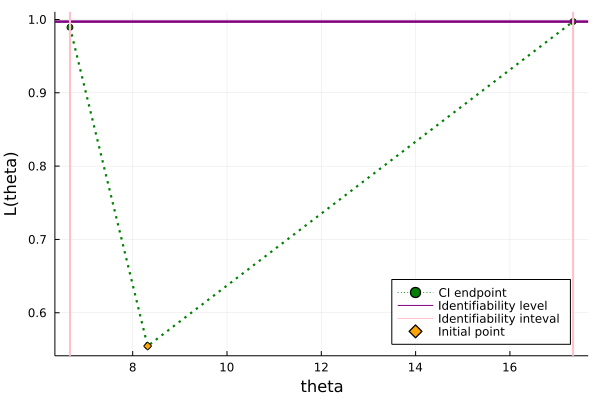

In [11]:
using LikelihoodProfiler

a0_ci = get_interval(θ0, 1, lsq_func,:CICO_ONE_PASS,
        loss_crit = α, scan_bounds = (1e-3,1e3), scale = fill(:log,length(θ0)))
plot(a0_ci, fmt = :png, legend=:bottomright)

Функция *update_profile_points!* позволяет дополнить профиль промежуточными точками

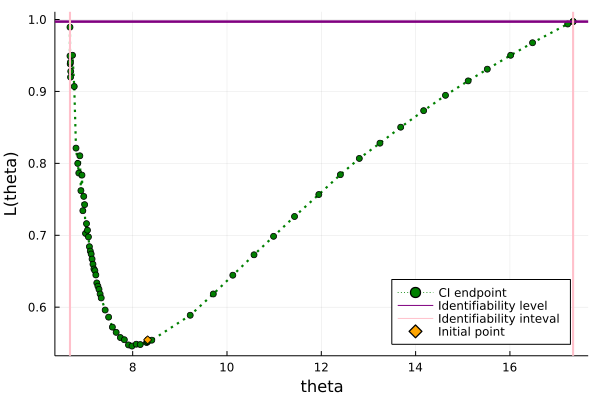

In [12]:
update_profile_points!(a0_ci)
plot(a0_ci, fmt = :png, legend=:bottomright)

## Доверительные коридоры

Алгоритм, реализованный в **LikelihoodProfiler**, может быть использован и для расчета более сложных доверительных характеристик: например, доверительных коридоров
- Доверительный коридор является обобщением понятия доверительный интервал для произвольных функций $\phi(\theta)$
- Для вычисления доверительного коридора нужно построить доверительный интервал для искомой функции от параметров $\phi(\theta)$ в каждый интересующий момент времени


Вычислим доверительный коридор для *Ncell* и дозировки *dose=5*

In [13]:
function bands_func(parampampam, i, dose=5.0)
    prob = ODEProblem((du,u,θ,t)->ode_func(du,u,θ,t,dose), u0, tspan, parampampam)
    sol = solve(
        prob, 
        AutoTsit5(Rosenbrock23()), 
        saveat=times
    )
    return sol[1,i]+sol[2,i]+sol[3,i]
end;

In [14]:
intervals = Vector{ParamInterval}(undef,length(times))
for i in eachindex(times)
    @time intervals[i] = get_interval(θ0, θ->bands_func(θ,i), lsq_func, :CICO_ONE_PASS,
        loss_crit = α, scan_bounds = (1e-3,1e3), theta_bounds = fill((1e-3,1e3),length(θ0)),scale = fill(:log,length(θ0)))
end

  9.964223 seconds (11.23 M allocations: 866.231 MiB, 2.67% gc time, 97.86% compilation time)
 10.496065 seconds (18.87 M allocations: 1.471 GiB, 4.63% gc time)
 11.821526 seconds (20.29 M allocations: 1.583 GiB, 4.51% gc time)
  9.417516 seconds (17.35 M allocations: 1.356 GiB, 4.47% gc time)
  9.034046 seconds (17.30 M allocations: 1.355 GiB, 5.17% gc time)
  9.354731 seconds (18.09 M allocations: 1.421 GiB, 4.27% gc time)


Нанесем коридор на график *Ncell*

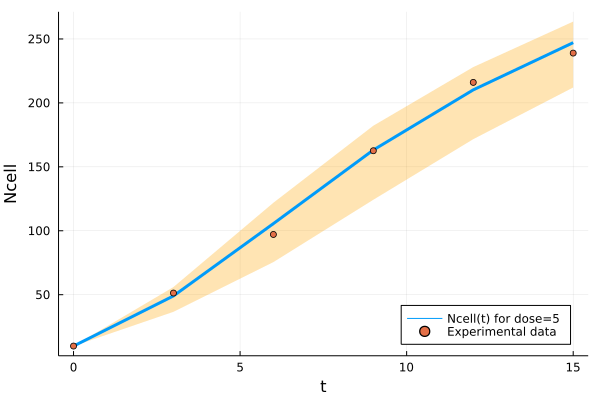

In [15]:
lbands = [iv.result[1].value for iv in intervals]
ubands = [iv.result[2].value for iv in intervals]
u = (sol[1,:]+sol[2,:]+sol[3,:])
plot(sol.t, u, xlabel = "t", ylabel = "Ncell", label="Ncell(t) for dose=5", line=3,
    ribbon = (u-lbands, ubands-u), fc=:orange, fa=0.3, fmt = :png, legend=:bottomright);
scatter!(times, df.Cell005, label = "Experimental data")

### Выводы

- Алгоритм может быть использован для вычисления различных доверительных характеристик: интервалов, коридоров
- Эффективность метода оперделяется тем, сколько раз потребовалось вычислить функцию правдоподобия для достижения граничной точки доверительного интервала. Метод CICO в среднем требует меньше вычислений, чем другие реализации профиля правдоподобия. Подробнее: [Borisov I, Metelkin E (2020)](https://doi.org/10.1371/journal.pcbi.1008495)
- Экономия вычислительных ресурсов оказывается особенно существенной при вычислении доверительных коридоров

### Ссылки

- LikelihoodProfiler https://github.com/insysbio/LikelihoodProfiler.jl
- Примеры https://github.com/insysbio/likelihoodprofiler-cases

### Дальнейшие планы и текущие недостатки метода

- Разбор случая, когда функция правдоподобия имеет экстремум в граничной точке доверительного интервала
- Случай отсутствия производных на границе доверительной области
- Связь точности метода с критериями остановки оптимизационной задачи
- Использование новых библиотек оптимизации

##  <center> Спасибо за внимание! </center>